# Train 3D landmarks detector

In [1]:
import os
import matplotlib
import cv2
from matplotlib import pyplot as plt
import numpy as np
from datatools import Loader3D, Aug3D, Generator
from traintools import plot_history, get_callbacks, create_dirs
from testtools import plot2D, plot3D

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # gpu id to use

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Main settings

In [2]:
data_dir = "300W"
project_name = "new"
imsize = (64, 64)
used_lmarks = None

logdir = create_dirs(project_name)

In [3]:
# Choise only needed landmarks or skip this cell
used_lmarks = []
for i in [8, 30, 31, 35, 36, 39, 42, 45, 48, 54, 62, 66]:
    used_lmarks += list(range(i*3, i*3+3))

## Data loaders initialization and checkup

In [4]:
# Init loader for training images
loader_train = Loader3D(data_dir=os.path.join(data_dir, "train_crop"), 
                        img_size=imsize, 
                        valid_size=0, 
                        annotation_file="annotations3D.txt",
                        augmenter=Aug3D(),
                        used_lmarks=used_lmarks)  
# Init loader for test/validation images
loader_valid = Loader3D(data_dir=os.path.join(data_dir, "test_crop"), 
                        img_size=imsize, 
                        valid_size=1, 
                        annotation_file="annotations3D.txt",
                        augmenter=None,
                        used_lmarks=used_lmarks)  

In [5]:
# Test a generator
n = 0
for x, y in Generator(loader_valid, 8).get_iterator(train=False):
    n += 1
    print(x.shape, y.shape)
    if n >= 3:
        break

(8, 64, 64, 1) (8, 36)
(8, 64, 64, 1) (8, 36)
(8, 64, 64, 1) (8, 36)


image min/max: 0.0 238.0


<Figure size 432x288 with 0 Axes>

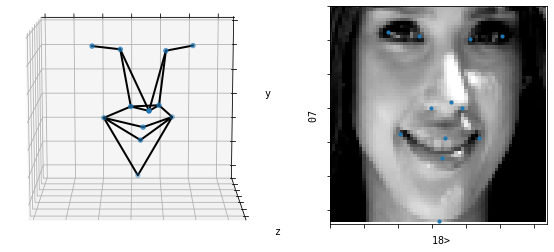

In [6]:
x, y = loader_train.get_item(loader_train.train_set[np.random.randint(10)])
plot3D(x[..., 0], y.reshape(-1, 3), view_pitch=10);
print("image min/max:", x.min(), x.max())

## Model initialization

In [10]:
from models import fconv3d as lmarks_model
from tensorflow.keras.optimizers import Adam

model = lmarks_model((imsize[1], imsize[0], 1), lmarks_count=12, normalize_input=1)
model.compile(loss="mean_absolute_error", optimizer=Adam())
print(model.summary(100))

Model: "landmarks-fconv3d"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
data (InputLayer)                            [(None, 64, 64, 1)]                     0              
____________________________________________________________________________________________________
lambda (Lambda)                              (None, 64, 64, 1)                       0              
____________________________________________________________________________________________________
conv11 (Conv2D)                              (None, 64, 64, 16)                      416            
____________________________________________________________________________________________________
pool01 (MaxPooling2D)                        (None, 32, 32, 16)                      0              
________________________________________________________________

## Start training

In [ ]:
gen_train = Generator(loader_train, 128)
gen_valid = Generator(loader_valid, 128)

history = model.fit_generator(generator=gen_train.get_iterator(train=True),
                              steps_per_epoch=20,
                              epochs=400,
                              initial_epoch=0,
                              validation_data=gen_valid.get_iterator(train=False),
                              validation_steps=25,
                              callbacks=get_callbacks(logdir, 0.001, 350),
                              use_multiprocessing=False
                              )

model.save(os.path.join(logdir, "checkpoints", "model_final.h5"))
plot_history(logdir, history)

## Model Validation

In [12]:
# Choise model to test
from tensorflow.keras.models import load_model
model = load_model(os.path.join("fconv3d-12", "checkpoints", "model_final.h5"))
model.compile(loss="mean_absolute_error")

In [14]:
# CALC TEST METRICS WITHOUT AUGMENTATION
bsize = 5
gen_test = Generator(loader_valid, bsize)
model.evaluate(gen_test.get_iterator(train=False), steps=len(loader_valid.valid_set)//bsize)

2/2 [==============================] - 0s 9ms/step - loss: 0.0193


0.01934025250375271

0.030793912708759308


<Figure size 432x288 with 0 Axes>

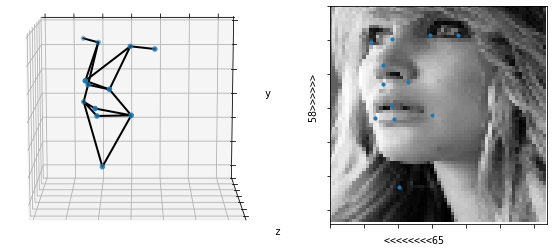

In [38]:
item_id = np.random.randint(10)
x, y = loader_valid.get_item(loader_valid.valid_set[item_id])

lmarks = model.predict(np.expand_dims(x, 0)).flatten()
print(model.evaluate(np.expand_dims(x, 0), np.expand_dims(y, 0), steps=1, verbose=0))
plot3D(x[..., 0], lmarks.reshape(-1, 3), view_pitch=10);

In [ ]:
import matplotlib.pyplot as plt
from shutil import rmtree
#from imageio import get_writer

def plot3D(frame, lmarks):
    lmarks = lmarks.copy().reshape((-1,3))
    lmarks[:, 0] = lmarks[:, 0]*x.shape[1]
    lmarks[:, 1] = lmarks[:, 1]*x.shape[0]
    lmarks[:, 2] = lmarks[:, 2]*(x.shape[0]+x.shape[1])*2
    lmarks3d = lmarks.copy()
    lmarks3d[:, 0] = x.shape[1]-lmarks3d[:, 0]

    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.get_zaxis().set_ticklabels([])

    xc, yc, zc = lmarks3d[:, 0], lmarks3d[:, 1], lmarks3d[:, 2]
    conts = [[11, 8, 10, 9, 11],
             [4, 5, 2, 1, 3, 6, 7],
             [5, 1, 6],
             [8, 2, 3, 9, 0, 8]]
    for cont in conts:
        ax.plot(xc[cont], yc[cont], zs=zc[cont])
    
    ax.scatter(lmarks3d[:, 0], lmarks3d[:, 1], lmarks3d[:, 2])
    #ax.azim = 45
    #ax.dist = 8
    #ax.elev = 20
    ax.view_init(180, 90)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(frame, cmap="gray")
    plt.scatter(lmarks[:, 0], lmarks[:, 1])
    plt.axis("off")

plot3D(x[..., 0], y.reshape(-1, 3))
plot3D(x[..., 0], lmarks.reshape(-1, 3))

In [ ]:
from testutils import CropTester
def keras_wrapper(img_crop):
    """
    input img_crop: face crop before resize
    output: landmarks as flatten np.array
    """
    net_input = cv2.resize(img_crop, model.input_shape[1:-1][::-1])
    net_input = (net_input.astype(np.float32)/255)
    net_input = net_input.reshape(1, net_input.shape[0], net_input.shape[1], 1)
    lmarks = model.predict(net_input)
    return lmarks

ct = CropTester(keras_wrapper, num_iterations=10)
ct.test_image("/media/hdd/public/Datasets/faces/300W/test_crop/helen/000009.png")
ct.mean_pixel_std()

In [ ]:
model = fcn3D((imsize[1], imsize[0], 1), 12, train_mode=False)
model.load_weights("cnn3d-12/checkpoints/model_final.h5", by_name=True, skip_mismatch=False)
model.save("cnn3d-12/checkpoints/model_infer.h5")

In [ ]:
!/usr/bin/python3.7 freeze_graph.py cnn3d-12/checkpoints/model_infer.h5